# Vectorization

1) [Clusterization](#clusterization)
2) [Transfert Georeferancing](#transfert-georeferencing)
3) [Creation of polygons](#creation-of-polygons)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from PIL import Image
from tqdm import tqdm
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape

### Clusterization

c:\ProgramData\Miniconda3\envs\PDM\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


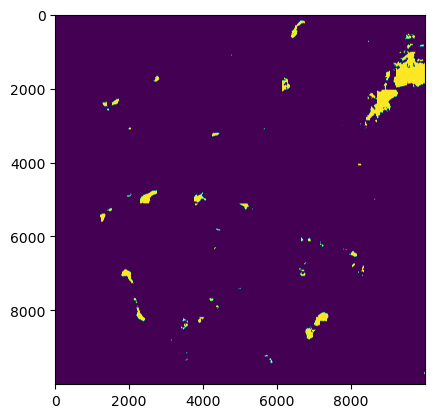

In [2]:
# load image
src_img = r"D:\GitHubProjects\Terranum_repo\LandSlides\segformerlandslides\data\test_vectorization\swissimage-dop10_2018_2599-1160_0.1_2056_final_prod_mask.tif"
src_img = r"D:\GitHubProjects\Terranum_repo\LandSlides\segformerlandslides\data\test_multi_resolution\swisstopo\model=20260107_173803_50_epochs_Longxi_Bern_v2_focal_dice_losses\2018_2599-1160_0.1_2056\img_final_prod_mask.tif"
img = Image.open(src_img)
img_arr = np.array(img)
plt.imshow(img)


In [ ]:
# extract coordinates of landslides
pos_ls = np.argwhere(img_arr)

In [4]:
# create cluster map
EPS = 3
MIN_SAMPLES = 20
clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(pos_ls)
cluster_labels = clustering.labels_
lst_clusters = set(cluster_labels)
print("Number of found clusters: ", len(lst_clusters))

Number of found clusters:  134


In [5]:
img_clusters = np.zeros(img_arr.shape)

# unpack coordinates
rows = pos_ls[:, 0]
cols = pos_ls[:, 1]

img_clusters[rows, cols] = cluster_labels
img_clusters[img_clusters == -1] = 0


In [6]:
# saving clusters
distinct_colors_rgb8 = [
    (230, 25, 75),    # red
    (60, 180, 75),    # green
    (255, 225, 25),   # yellow
    (0, 130, 200),    # blue
    (245, 130, 48),   # orange
    (145, 30, 180),   # purple
    (70, 240, 240),   # cyan
    (240, 50, 230),   # magenta
    (210, 245, 60),   # lime
    (250, 190, 212),  # pink
    (0, 128, 128),    # teal
    (220, 190, 255),  # lavender
    (170, 110, 40),   # brown
    (255, 250, 200),  # beige
    (128, 0, 0),      # dark red
    (0, 0, 128),      # navy
    (128, 128, 0),    # olive
    (255, 215, 180),  # peach
    (0, 0, 0),        # black
    (128, 128, 128),  # gray
]
distinct_colors_rgb8 = [(x, y, z, 255) for (x,y,z) in distinct_colors_rgb8]
MIN_CLUSTER_SIZE = 1000
rgb_clusters = np.zeros((img_clusters.shape[0], img_clusters.shape[1], 4))
# rgb_img[:,:,3] = 255
for _, cluster in tqdm(enumerate(lst_clusters), total=len(lst_clusters)):
    if np.sum(img_clusters == cluster) < MIN_CLUSTER_SIZE:
        rgb_clusters[img_clusters == cluster] = [255, 255, 255, 0]
        img_clusters[img_clusters == cluster] = 0
    else:
        id_color = cluster % len(distinct_colors_rgb8)
        rgb_clusters[img_clusters == cluster] = distinct_colors_rgb8[id_color]

# Background in white
rgb_clusters[img_clusters == 0] = (255,255,255, 0)

100%|██████████| 134/134 [00:55<00:00,  2.41it/s]


In [7]:
# save results
src_img = os.path.join(os.path.dirname(src_img), f'clusters_eps_{EPS}_min_samp_{MIN_SAMPLES}_rgb.tif')
src_mask = os.path.join(os.path.dirname(src_img), f'clusters_eps_{EPS}_min_samp_{MIN_SAMPLES}_mask.tif')
Image.fromarray(rgb_clusters.astype(np.uint8), 'RGBA').save(src_img)
Image.fromarray(img_clusters.astype(np.uint16)).save(src_mask)

In [4]:
# small grid search
do_process_gridsearch = True
if do_process_gridsearch:
    lst_eps = [1,2,3,5,10]
    lst_min_samples = [3,5,10,20,50]
    gs = np.zeros((len(lst_eps), len(lst_min_samples)))
    for eps_id, eps in tqdm(enumerate(lst_eps), total=len(lst_eps)):
        for min_id, min_samp in enumerate(lst_min_samples):
            clustering = DBSCAN(eps=eps, min_samples=min_samp).fit(pos_ls)
            gs[eps_id, min_id] = len(set(clustering.labels_))
    print(gs)

100%|██████████| 5/5 [05:35<00:00, 67.19s/it]

[[157. 163.   1.   1.   1.]
 [150. 148. 145.   1.   1.]
 [145. 143. 138. 134.   1.]
 [118. 117. 110. 106. 110.]
 [ 96.  96.  92.  90.  86.]]


### Transfert georeferencing

In [9]:
# first transfert geo-infos from original to product
def geo_transfert(img_geo, img_target):
    with rasterio.open(img_geo) as src:
        crs = src.crs
        transform = src.transform
        profile = src.profile

    with rasterio.open(img_target) as pred:
        pred_data = pred.read()
        pred_profile = pred.profile

    pred_profile.update({
        "crs": crs,
        "transform": transform
    })
    src_new_target = os.path.splitext(img_target)[0] +"_georef.tif"
    with rasterio.open(src_new_target, "w", **pred_profile) as dst:
        dst.write(pred_data)
    return src_new_target

In [13]:
# test
src_origin = r"D:\GitHubProjects\Terranum_repo\LandSlides\segformerlandslides\data\test_multi_resolution\swisstopo\model=20260107_173803_50_epochs_Longxi_Bern_v2_focal_dice_losses\2018_2599-1160_0.1_2056\img.tif"
src_target = r"D:\GitHubProjects\Terranum_repo\LandSlides\segformerlandslides\data\test_multi_resolution\swisstopo\model=20260107_173803_50_epochs_Longxi_Bern_v2_focal_dice_losses\2018_2599-1160_0.1_2056\img_final_prod_proba_mask.tif"
geo_transfert(src_origin, src_target)

c:\ProgramData\Miniconda3\envs\PDM\lib\site-packages\rasterio\__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


'D:\\GitHubProjects\\Terranum_repo\\LandSlides\\segformerlandslides\\data\\test_multi_resolution\\swisstopo\\model=20260107_173803_50_epochs_Longxi_Bern_v2_focal_dice_losses\\2018_2599-1160_0.1_2056\\img_final_prod_proba_mask_georef.tif'

### Creation of polygons

In [11]:
# First give georeferancing to clusters
src_origin = r"D:\GitHubProjects\Terranum_repo\LandSlides\segformerlandslides\data\test_multi_resolution\swisstopo\model=20260107_173803_50_epochs_Longxi_Bern_v2_focal_dice_losses\2018_2599-1160_0.1_2056\img.tif"
src_target = r"D:\GitHubProjects\Terranum_repo\LandSlides\segformerlandslides\data\test_multi_resolution\swisstopo\model=20260107_173803_50_epochs_Longxi_Bern_v2_focal_dice_losses\2018_2599-1160_0.1_2056\clusters_eps_3_min_samp_20_mask.tif"
src_target = geo_transfert(src_origin, src_target)

In [12]:
with rasterio.open(src_target) as src:
    mask = src.read(1)
    transform = src.transform
    crs = src.crs

    # Extract polygons AND their raster values
    records = [
        {"geometry": shape(geom), "raster_val": value}
        for geom, value in shapes(mask, transform=transform)
        if value != 0 # optional: ignore background
    ]

# Build georeferenced GeoDataFrame
gdf = gpd.GeoDataFrame(records, crs=crs)

# Save to GeoPackage
src_polygons = os.path.splitext(src_target)[0] + '_landslides.gpkg'
gdf.to_file(src_polygons, driver="GPKG")